## Introducción: ¿Qué vamos a aprender hoy?

En esta guía, vas a aprender a construir una aplicación web simple, usando Python y Gradio, que te va a permitir subir un archivo de audio (como una reunión, una entrevista o una clase), transcribirlo automáticamente con la precisión de Whisper y luego generar un resumen conciso y contextualizado con Gemini.

Esto es súper útil para:
*   Ponerte al día rápido con reuniones a las que no pudiste ir.
*   Extraer los puntos clave de una entrevista.
*   Hacer síntesis de charlas o conferencias.

Vas a tener el poder de procesar información de audio en texto y luego resumirla de forma inteligente.

## Prerrequisitos (¡Atento acá!):

Antes de arrancar a tipear código, asegurate de tener esto listo:

1.  **Google Colab con GPU habilitada**: Para que Whisper funcione rápido, vas a necesitar una GPU. Andá a `Entorno de ejecución (Runtime)` > `Cambiar tipo de entorno de ejecución (Change runtime type)` y seleccioná `GPU` como acelerador de hardware. ¡Es fundamental!
2.  **API Key de Google AI Studio**: Vas a necesitar una clave de API para usar Gemini. Andá a [Google AI Studio](https://aistudio.google.com/app/apikey) y generá una nueva clave. ¡Es gratis para empezar!
3.  **Configurar tu API Key en Colab Secrets**: Por seguridad, nunca pongas tu API Key directamente en el código. Colab te permite guardarlas como "secretos". Fijate en la barra lateral izquierda, hay un ícono de una llave (`🔧`). Clickear ahí, agregá un nuevo secreto con el nombre `GOOGLE_API_KEY` y pegá el valor de tu clave que obtuviste en el paso anterior.

Una vez que tengas todo esto, ¡estamos listos para meterle mano al código!

## Pasos: Armando nuestra aplicación de Transcripción y Resumen

Vamos a recorrer el código celda por celda, entendiendo qué hace cada parte.

### Paso 1: Instalamos las dependencias

Primero lo primero: necesitamos instalar las librerías de Python que vamos a usar. `google-genai` para interactuar con Gemini, `gradio` para crear la interfaz web, `transformers` y `torch` para Whisper, y `accelerate` para optimizar el rendimiento.

**Explicación:**
Este comando instala o actualiza todas las librerías necesarias. El `-U` las actualiza si ya las tenés, y el `-q` (quiet) hace que la salida sea más limpia, así no te abrumás con tanto texto.

In [1]:
# Celda 1: Instalación de dependencias
# %%capture
!pip install -U -q google-genai gradio transformers torch torchvision accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.1/256.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 922.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Paso 2: Conectamos la API Key de Google

Para que nuestra app pueda hablar con los modelos de Gemini, necesita tu API Key. La vamos a cargar de forma segura desde los secretos de Colab.

**Explicación:**
Acá importamos `userdata` de `google.colab`, que nos permite acceder a los secretos que guardaste. Luego, intentamos obtener la clave `GOOGLE_API_KEY`. Si por alguna razón no la configuraste o la tipiaste mal, el programa te va a tirar un error claro con instrucciones para que lo arregles. ¡Es clave que esto funcione bien!

In [2]:
# Celda 2: Configuración de API Key
from google.colab import userdata
import os

In [3]:
# Obtener la API key de Google (debes configurarla en Colab Secrets)
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

if not GOOGLE_API_KEY:
    print("❌ ERROR: Necesitas configurar tu GOOGLE_API_KEY en los secretos de Colab")
    print("📋 Ve a: Configuración (🔧) > Secretos > Agregar nuevo secreto")
    print("🔑 Nombre: GOOGLE_API_KEY")
    print("💡 Valor: Tu API key de Google AI Studio")
else:
    print("✅ API Key de Google configurada correctamente")

✅ API Key de Google configurada correctamente


### Paso 3: Importamos y configuramos los modelos

Importamos las librerías restantes y definimos qué modelos de Whisper y Gemini vamos a usar.

**Explicación:**
Acá importamos todo lo necesario. `torch` es la base para las operaciones de deep learning, `transformers` nos da acceso a Whisper, `gradio` para la interfaz y `genai` para Gemini. También configuramos un `logging` básico para ver qué está pasando.

In [4]:
# Celda 3: Imports y configuración
import torch
from transformers import pipeline
import gradio as gr
from google import genai
from google.genai import types
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO)

# Configurar cliente de Gemini
cliente = genai.Client(api_key=GOOGLE_API_KEY)

Fijate que definimos dos variables: `ASR_MODEL` para Whisper y `GEMINI_MODEL` para el modelo de lenguaje de Google. Los `param` y `allow-input` que ves son específicos de Colab para que te aparezcan desplegables y puedas elegir fácilmente qué modelo usar sin modificar el código.

In [5]:
# Modelos disponibles
ASR_MODEL = "openai/whisper-small" # @param ["openai/whisper-tiny", "openai/whisper-base", "openai/whisper-small", "openai/whisper-medium", "openai/whisper-large-v3"] {allow-input: true}
GEMINI_MODEL = "gemini-2.5-flash-preview-05-20" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash-preview-05-20","gemini-2.5-pro-preview-05-06"] {"allow-input":true, isTemplate: true}

print(f"🤖 Modelo ASR: {ASR_MODEL}")
print(f"🧠 Modelo LLM: {GEMINI_MODEL}")

🤖 Modelo ASR: openai/whisper-small
🧠 Modelo LLM: gemini-2.5-flash-preview-05-20


### Paso 4: Inicializamos el modelo de Transcripción (Whisper)

Aquí es donde cargamos el modelo de Whisper. Es importante que detecte si tenés una GPU (device=0) para usarla, si no, usará la CPU (device=-1).

**Explicación:**
Esta celda es crucial. Configura `device` y `torch_dtype` para aprovechar la GPU al máximo. Luego, usa la función `pipeline` de `transformers` para cargar el modelo de Whisper. Esto simplifica mucho la interacción con el modelo de reconocimiento de voz.

In [6]:
# Celda 4: Configuración de ASR
device = 0 if torch.cuda.is_available() else -1
torch_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

print(f"💻 Dispositivo: {'GPU' if device == 0 else 'CPU'}")
print(f"📊 Tipo de datos: {torch_dtype}")

try:
    print("🔄 Cargando modelo Whisper...")
    asr_pipe = pipeline(
        "automatic-speech-recognition",
        model=ASR_MODEL,
        device=device,
        torch_dtype=torch_dtype,
        return_timestamps=True,
        chunk_length_s=30,
        stride_length_s=5
    )
    print("✅ Modelo Whisper cargado exitosamente")

except Exception as e:
    print(f"❌ Error cargando ASR: {e}")
    raise e

💻 Dispositivo: GPU
📊 Tipo de datos: torch.bfloat16
🔄 Cargando modelo Whisper...


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).


✅ Modelo Whisper cargado exitosamente


### Paso 5: Creamos la función de Sumarización con Gemini

Ahora viene la magia de Gemini. Creamos una función que toma el texto transcrito y lo resume, usando diferentes "prompts" (instrucciones para la IA) según el tipo de resumen que le pidamos y el contexto del audio (reunión, entrevista, etc.).

**Explicación:**
La función `sumarizar_con_gemini` es el cerebro del resumen. Recibe el texto, el `tipo_resumen` que querés y el `contexto` (reunión, entrevista, etc.). Dentro de la función, vas a ver un diccionario `prompts_contexto` que tiene distintas formas de preguntarle a Gemini según lo que necesitemos. Por ejemplo, si elegís "reunión" y "Resumen ejecutivo", Gemini recibe una instrucción específica para ese caso.
Probá a cambiar los prompts para ver cómo afecta el resultado.

In [7]:
# Celda 5: Funciones de sumarización con Gemini
def sumarizar_con_gemini(texto, tipo_resumen="Detallado", contexto="reunión"):
    """
    Sumariza texto usando Gemini con prompts optimizados para diferentes contextos
    """
    if not texto.strip():
        return "❌ No hay texto para sumarizar"

    # Prompts especializados según el contexto
    prompts_contexto = {
        "reunión": {
            "Muy breve": f"""Resumí esta transcripción de reunión en una sola oración que capture el tema principal:

Transcripción: {texto}

Resumen:""",

            "Resumen ejecutivo": f"""Creá un resumen ejecutivo de esta reunión en 3-4 puntos clave:

Transcripción: {texto}

Resumen ejecutivo:""",

            "Detallado con accionables": f"""Analizá esta transcripción de reunión y proporcioná:
1. Resumen de los temas principales
2. Decisiones tomadas
3. Próximos pasos o acciones

Transcripción: {texto}

Análisis:""",

            "Puntos clave": f"""Extraé los 5 puntos más importantes de esta reunión:

Transcripción: {texto}

Puntos clave:"""
        },

        "entrevista": {
            "Muy breve": f"""Resumí esta entrevista en una oración:

Transcripción: {texto}

Resumen:""",

            "Resumen ejecutivo": f"""Resumí los puntos principales de esta entrevista:

Transcripción: {texto}

Resumen:""",

            "Detallado con accionables": f"""Analizá esta entrevista y destacá:
1. Temas principales discutidos
2. Respuestas clave del entrevistado
3. Insights importantes

Transcripción: {texto}

Análisis:""",

            "Puntos clave": f"""Listá los puntos más importantes de esta entrevista:

Transcripción: {texto}

Puntos clave:"""
        },

        "conferencia": {
            "Muy breve": f"""Resumí esta conferencia en una oración:

Transcripción: {texto}

Resumen:""",

            "Resumen ejecutivo": f"""Creá un resumen de esta conferencia:

Transcripción: {texto}

Resumen:""",

            "Detallado con accionables": f"""Resumí esta conferencia incluyendo:
1. Tema principal
2. Conceptos clave explicados
3. Conclusiones importantes

Transcripción: {texto}

Resumen detallado:""",

            "Puntos clave": f"""Extraé los conceptos más importantes de esta conferencia:

Transcripción: {texto}

Conceptos clave:"""
        }
    }

    # Seleccionar prompt
    prompt = prompts_contexto.get(contexto, prompts_contexto["reunión"]).get(tipo_resumen)

    if not prompt:
        # Fallback genérico
        prompt = f"Resumí el siguiente texto de manera clara y concisa:\n\n{texto}\n\nResumen:"

    try:
        print(f"🧠 Generando resumen con Gemini ({tipo_resumen})...")
        respuesta = cliente.models.generate_content(
            model=GEMINI_MODEL,
            contents=[prompt]
        )

        resultado = respuesta.text.strip()

        if not resultado:
            return "❌ Gemini no pudo generar un resumen"

        return resultado

    except Exception as e:
        print(f"❌ Error en Gemini: {e}")
        return f"❌ Error al generar resumen: {str(e)}"

### Paso 6: Definimos la función principal de procesamiento de audio

Esta es la función que va a orquestar todo: toma el archivo de audio, lo manda a Whisper para transcribir y luego usa Gemini para resumir esa transcripción.

**Explicación:**
Esta función es el cerebro de nuestro sistema. Primero, hace algunas validaciones del archivo de audio que subiste. Luego, llama a `asr_pipe` (Whisper) para obtener la transcripción. La salida de Whisper puede variar, así que hay un código para asegurarnos de extraer el texto correctamente. Finalmente, toma esa transcripción y se la pasa a `sumarizar_con_gemini` para obtener el resumen. También le agrega algo de información extra al resumen para que sepas qué modelo y configuración se usaron.

In [8]:
# Celda 6: Función principal de procesamiento
def process_audio_with_gemini(audio_file_path, tipo_resumen, contexto):
    """
    Procesa audio: transcribe con Whisper y sumariza con Gemini
    """
    if not audio_file_path:
        return "❌ No se ha cargado ningún archivo de audio", "❌ Sin audio para procesar"

    try:
        # Validaciones básicas
        if not os.path.exists(audio_file_path):
            return "❌ El archivo no existe", "❌ Archivo no encontrado"

        file_size = os.path.getsize(audio_file_path)
        if file_size < 1024:  # Menos de 1KB
            return "❌ El archivo es muy pequeño", "❌ Archivo muy pequeño"

        print(f"📁 Procesando: {audio_file_path} ({file_size} bytes)")

        # PASO 1: Transcripción con Whisper
        print("🎯 Iniciando transcripción con Whisper...")
        try:
            result = asr_pipe(audio_file_path)
            print(f"📝 Resultado ASR: {type(result)}")
        except Exception as asr_error:
            print(f"❌ Error en transcripción: {asr_error}")
            return f"❌ Error en transcripción: {str(asr_error)}", "❌ Error en transcripción"

        # Extraer texto de la transcripción
        raw_transcript = ""

        if isinstance(result, dict):
            if "text" in result:
                raw_transcript = result["text"].strip()
            elif "chunks" in result:
                chunks = result["chunks"]
                raw_transcript = " ".join([chunk["text"].strip() for chunk in chunks if "text" in chunk])
        elif isinstance(result, str):
            raw_transcript = result.strip()
        elif isinstance(result, list) and len(result) > 0:
            if isinstance(result[0], dict) and "text" in result[0]:
                raw_transcript = " ".join([chunk["text"].strip() for chunk in result if "text" in chunk])

        print(f"📄 Transcripción obtenida: {len(raw_transcript)} caracteres")

        if not raw_transcript:
            return "❌ No se pudo obtener transcripción del audio", "❌ Transcripción vacía"

        if len(raw_transcript) < 50:
            return raw_transcript, "📝 El texto es muy corto para un resumen útil"

        # PASO 2: Sumarización con Gemini
        print("🧠 Generando resumen con Gemini...")
        summary = sumarizar_con_gemini(raw_transcript, tipo_resumen, contexto)

        # Agregar metadata al resumen
        metadata = f"📊 **Resumen generado con Gemini {GEMINI_MODEL}**\n"
        metadata += f"🎯 Tipo: {tipo_resumen} | 📋 Contexto: {contexto.title()}\n\n"
        summary_with_metadata = metadata + summary

        return raw_transcript, summary_with_metadata

    except Exception as e:
        error_msg = f"❌ Error durante el procesamiento: {str(e)}"
        print(error_msg)
        return error_msg, error_msg

### Paso 7: Armamos la Interfaz de Usuario con Gradio

Para que cualquiera pueda usar nuestra aplicación sin saber de código, vamos a crear una interfaz web interactiva con Gradio. ¡Es re fácil!

**Explicación:**
Acá es donde creamos la interfaz visual. Definimos `gr.Audio` para que el usuario pueda subir su archivo, y dos `gr.Dropdown` para elegir el tipo de resumen y el contexto. Los resultados se van a mostrar en dos `gr.Textbox`. Finalmente, unimos todo en `gr.Interface`, diciéndole qué función ejecutar (`process_audio_with_gemini`) con qué inputs y dónde mostrar los outputs.
Gradio se encarga de generar toda la web por vos.

In [9]:
# Celda 7: Interfaz Gradio
def create_audio_interface():
    """Crea la interfaz de Gradio"""

    # Inputs
    audio_input = gr.Audio(
        sources=["upload"],
        type="filepath",
        label="🎵 Subir Archivo de Audio",
        format="wav"
    )

    tipo_resumen = gr.Dropdown(
        choices=[
            "Muy breve",
            "Resumen ejecutivo",
            "Detallado con accionables",
            "Puntos clave"
        ],
        label="📋 Tipo de Resumen",
        value="Resumen ejecutivo",
        info="Selecciona el estilo de resumen que prefieras"
    )

    contexto = gr.Dropdown(
        choices=["reunión", "entrevista", "conferencia"],
        label="🎯 Contexto del Audio",
        value="reunión",
        info="Ayuda a optimizar el resumen para el tipo de contenido"
    )

    # Outputs
    output_transcript = gr.Textbox(
        label="📝 Transcripción Completa (Whisper)",
        lines=12,
        show_copy_button=True,
        placeholder="La transcripción completa aparecerá aquí..."
    )

    output_summary = gr.Textbox(
        label="🧠 Resumen Inteligente (Gemini)",
        lines=10,
        show_copy_button=True,
        placeholder="El resumen generado por IA aparecerá aquí..."
    )

    # Interfaz
    interface = gr.Interface(
        fn=process_audio_with_gemini,
        inputs=[audio_input, tipo_resumen, contexto],
        outputs=[output_transcript, output_summary],
        title="🎙️ Analizador de Audio con IA - Whisper + Gemini",
        description="""
        ### 🚀 **Potenciado por la mejor IA disponible:**
        - **🎯 Transcripción:** OpenAI Whisper (precisión superior)
        - **🧠 Sumarización:** Google Gemini (comprensión avanzada)

        ### 📋 **Instrucciones:**
        1. **Sube tu audio** (WAV, MP3, M4A, etc.)
        2. **Selecciona el tipo de resumen** que necesitas
        3. **Elige el contexto** (reunión, entrevista, conferencia)
        4. **¡Obtén resultados profesionales!**

        ### ⚡ **Características:**
        - ✅ Maneja audios de cualquier duración
        - ✅ Resúmenes contextualizados e inteligentes
        - ✅ Múltiples formatos de salida
        - ✅ Copia fácil de resultados
        """,
        examples=[],
        cache_examples=False,
        allow_flagging="never",
        theme=gr.themes.Soft()
    )

    return interface

### Paso 8: Lanzamos la aplicación

¡Ya casi estamos! Con esta última celda, vamos a poner en marcha la interfaz de Gradio para que la puedas usar.

**Explicación:**
Aquí simplemente creamos la interfaz llamando a `create_audio_interface()` y luego la lanzamos con `app.launch()`. El parámetro `share=True` es súper útil en Colab porque te va a dar una URL pública temporal para que puedas acceder a tu app desde tu celular o compartirla. Vas a ver el link en la salida de esta celda. También incluimos información importante sobre la configuración, costos y qué hacer si algo falla.

In [ ]:
# Celda 8: Lanzar la aplicación
try:
    print("🚀 Creando interfaz...")
    app = create_audio_interface()

    print("🌐 Lanzando aplicación...")
    app.launch(
        share=True,      # URL pública para Colab
        debug=True,      # Información de debug
        show_error=True  # Mostrar errores en la UI
    )

except Exception as e:
    print(f"❌ Error al lanzar la aplicación: {e}")

# Información adicional para el usuario
print("""
🔧 **Configuración requerida:**
1. GPU habilitada en Colab (Runtime > Change runtime type > GPU)
2. API Key de Google configurada en secretos de Colab
3. Archivos de audio en formatos estándar (WAV, MP3, etc.)

📊 **Costos estimados de Gemini:**
- Gemini 2.0 Flash Lite: ~$0.075 per 1M tokens
- Una transcripción típica de 10 min ≈ 1500 tokens
- Costo por resumen: ~$0.0001 USD

🆘 **Si hay errores:**
1. Verifica que la API key esté configurada
2. Asegúrate de tener GPU habilitada
3. Prueba con archivos de audio más pequeños primero
""")

🚀 Creando interfaz...


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


🌐 Lanzando aplicación...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d9b6b869331ef1a542.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


📁 Procesando: /tmp/gradio/24fd910c2c9c1ee612630ede2f95f164533f84f59def5086c327148aa3df6fb1/Grabación.wav (1603628 bytes)
🎯 Iniciando transcripción con Whisper...


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


📝 Resultado ASR: <class 'dict'>
📄 Transcripción obtenida: 83 caracteres
🧠 Generando resumen con Gemini...
🧠 Generando resumen con Gemini (Puntos clave)...
📁 Procesando: /tmp/gradio/24fd910c2c9c1ee612630ede2f95f164533f84f59def5086c327148aa3df6fb1/Grabación.wav (1603628 bytes)
🎯 Iniciando transcripción con Whisper...
📝 Resultado ASR: <class 'dict'>
📄 Transcripción obtenida: 83 caracteres
🧠 Generando resumen con Gemini...
🧠 Generando resumen con Gemini (Detallado con accionables)...
📁 Procesando: /tmp/gradio/24fd910c2c9c1ee612630ede2f95f164533f84f59def5086c327148aa3df6fb1/Grabación.wav (1603628 bytes)
🎯 Iniciando transcripción con Whisper...
📝 Resultado ASR: <class 'dict'>
📄 Transcripción obtenida: 83 caracteres
🧠 Generando resumen con Gemini...
🧠 Generando resumen con Gemini (Muy breve)...


## Ejercicios y Práctica:

Para que sigas practicando y afiances lo que aprendiste, te propongo algunos ejercicios:

1.  **Probá distintos audios**: Subí audios de diferentes duraciones (cortos, medianos) y formatos (MP3, WAV, M4A). ¿Cómo se comporta la transcripción? ¿Y el resumen?
2.  **Experimentá con los tipos de resumen y contextos**: Subí el mismo audio y probá las cuatro opciones de resumen (`Muy breve`, `Resumen ejecutivo`, `Detallado con accionables`, `Puntos clave`) y los tres contextos (`reunión`, `entrevista`, `conferencia`). ¿Notas diferencias en los resúmenes? ¿Cuál te resulta más útil para cada caso?
3.  **Cambia el modelo de Whisper**: Andá a la celda donde definimos `ASR_MODEL` (debajo de la celda de Imports y Modelos) y probá con `openai/whisper-large-v3`. Ejecutá esa celda y luego la de inicialización de ASR. ¿Mejora la precisión de la transcripción? (¡Ojo, el `large-v3` es más pesado y puede tardar más o requerir más GPU!)
4.  **Añade un nuevo tipo de resumen o contexto**:
    *   En la función `sumarizar_con_gemini`, dentro del diccionario `prompts_contexto`, agregá un nuevo tipo de resumen, por ejemplo, `"Preguntas y Respuestas"`.
    *   Podrías agregar un nuevo contexto, por ejemplo, `"clase"` o `"podcast"`.
    *   Luego, actualizá el `gr.Dropdown` en la función `create_audio_interface` para que tu nueva opción aparezca en la interfaz. ¡Vas a tener que reiniciar la app de Gradio después de esos cambios!
5.  **Ajusta los prompts**: ¿Creés que un resumen "muy breve" para una reunión podría ser más útil si solo dice "Las decisiones más importantes fueron..."? ¡Modificá los `prompts_contexto` a tu gusto y probá!

## Debugging (Cuando algo no va):

*   Si la app no se lanza, revisá la consola de Colab. Los mensajes de `print` que agregamos te van a dar pistas.
*   El error más común es no tener la API Key bien configurada o no tener la GPU habilitada. Siempre chequeá esos dos primero.
*   Si la transcripción es mala, probá con un audio más claro o considerá cambiar a un modelo Whisper más grande (como `large-v3`).
*   Si el resumen no es lo que esperás, revisá el `prompt` que le estás mandando a Gemini. Es clave que la instrucción sea clara y específica.

## Conclusión:

¡Felicitaciones! Hoy no solo aprendiste a usar dos modelos de IA muy potentes, como Whisper y Gemini, sino que también armaste una aplicación funcional con Gradio. Ya podés transcribir y resumir audios de manera automática, lo cual es una habilidad muy valiosa en el mundo de hoy.

**¿Qué sigue?**
*   Podés explorar cómo integrar esto en otras aplicaciones.
*   Investigar otros modelos de `transformers` para tareas diferentes.
*   Profundizar en las capacidades de Gemini para otras aplicaciones de lenguaje natural.
*   ¡Experimentar con Gradio para crear interfaces más complejas!

**Bonus: mel spectrogram**

Asi ve **Wishper** los audios

Text(0.5, 1.0, 'Así ve Whisper tu audio')

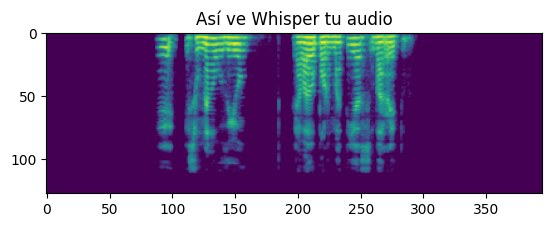

In [ ]:
import librosa
import matplotlib.pyplot as plt

# Mostrar cómo Whisper "ve" el audio
audio, sr = librosa.load('/content/Grabación (3).mp3')
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
plt.imshow(librosa.power_to_db(mel_spec))
plt.title("Así ve Whisper tu audio")